In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import root_scalar

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

# Toy problem

In [2]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)
x_true = x.copy()

In [3]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [4]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

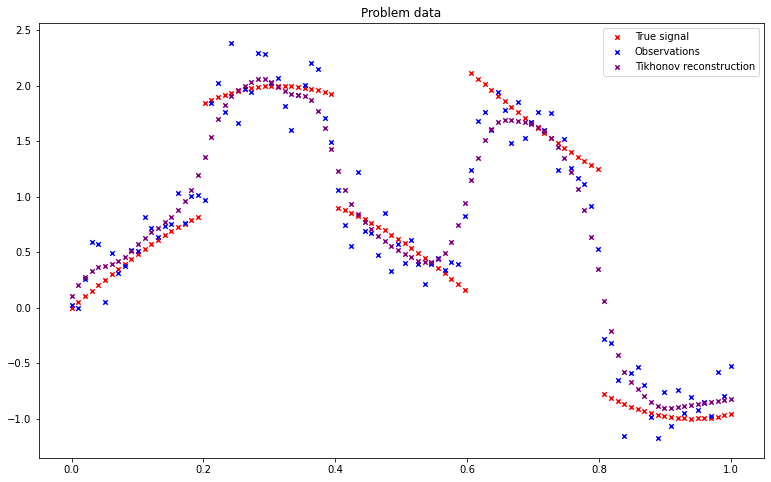

In [5]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

# CGLS for tikhonov problem

In [214]:
# Original CGLS code
def cgls_for_tikhonov(A, b, noise_sigma, lam=1.0, maxits=100, tau=1.03, early_stopping=True):
    """
    """

    # Whitening by noise variance
    A = (1.0/noise_sigma)*A
    b = (1.0/noise_sigma)*b

    # Get shape
    n = A.shape[1]
    m_A = A.shape[0]

    # Make stacked LinearOperator
    def _matvec(v):
        p1 = A @ v
        p2 = np.sqrt(lam)*v
        return np.hstack([p1, p2])
    
    def _rmatvec(v):
        v1 = v[:m_A]
        v2 = v[m_A:]
        # print(A.T.shape)
        # print(v1.shape)
        return np.sqrt(lam)*v2 + (A.T @ v1)
    
    C = LinearOperator(shape=(m_A+n,n), matvec=_matvec, rmatvec=_rmatvec)

    # Make stacked data
    btilde = np.hstack([b, np.zeros(n)])


    # Setup
    n = C.shape[1]
    m = C.shape[0]
    x = np.zeros(n)
    r_prev = btilde - (C @ x)
    #print(r_prev.shape)
    #print(C.T.shape)
    d_prev = C.T @ r_prev
    #print(d_prev.shape)
    

    # Tracking
    squared_residuals = []
    squared_res = np.linalg.norm((C @ x) - btilde)**2
    squared_residuals.append(squared_res)
    n_iterations = 0

    for k in range(maxits):

        # CGLS iteration
        alpha = (np.linalg.norm(C.T @ r_prev)**2)/(np.linalg.norm(C @ d_prev)**2)
        x = x + alpha*d_prev
        r_next = r_prev - alpha*(C @ d_prev)
        beta = (np.linalg.norm(C.T @ r_next)**2/(np.linalg.norm(C.T @ r_prev)**2))
        d_next = (C.T @ r_next) + beta*d_prev

        d_prev = d_next
        r_prev = r_next

        # Track this
        n_iterations += 1
        squared_res = np.linalg.norm((C @ x) - btilde)**2
        squared_residuals.append(squared_res)

        if early_stopping and (squared_res < tau*m):
            break

    # Re-scale by lambda

    data = {
        "x": x,
        "n_iterations": n_iterations,
        "squared_residuals": squared_residuals,
    }

    return data

In [221]:
data = cgls_for_tikhonov(F, y, noise_sigma, lam=1e1, maxits=100, early_stopping=True, tau=1.05)

In [222]:
print(data["n_iterations"])

100


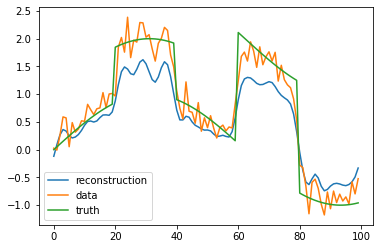

In [223]:
plt.plot(data["x"], label="reconstruction")
plt.plot(y, label="data")
plt.plot(x_true, label="truth")
plt.legend()
plt.show()